# <center>**02_train_cnn_model** </center>

### Table of Contents

1. **Notebook Overview**
   - Objective of Experiment 1: Binary classification of Calcific Tendinitis (CTRC).
   - Rationale for using a fine-tuned VGG19 architecture.
   - Integration of images from multiple workstations (CZC, RAD, MIN).
   - Strategy for model validation and generalizability.

2. **Environment Setup**
   - Import of core scientific libraries: `numpy`, `pandas`, `matplotlib`.
   - TensorFlow/Keras configuration for deep learning.
   - GPU memory management and verbosity control for clean execution.

3. **Data Loading & Subset Configuration**
   - Definition of training and test subsets from institutional databases.
   - Path management and verification of image-metadata consistency.
   - Dataset distribution analysis by acquisition workstation.
   - Implementation of **5-Fold Stratified Cross-Validation**.

4. **Custom Data Generation Pipeline**
   - Implementation of the `DataGenerator` class (Keras Sequence).
   - Rationale for batch-wise loading to manage high-volume medical imaging data.
   - Real-time preprocessing and synchronization of images and labels.

5. **CNN Model Architecture & Training Strategy**
   - Transfer Learning setup using the VGG19 backbone.
   - Custom classification head: Global Max Pooling (GMP) and Sigmoid activation.
   - Hyperparameter configuration and fine-tuning of convolutional layers.
   - Execution of the training loops across all validation folds.
   - Monitoring of accuracy and loss dynamics for training and validation sets.
   - Strategy for saving model weights and tracking convergence.

6. **Summary and Conclusions**
   - Insights into the impact of multi-workstation data on model performance.
   - Role of this trained CNN as a foundation for future hybrid ML experiments.

### **1. Notebook Overview**

This notebook implements the end-to-end training and optimization pipeline for a Convolutional Neural Network (CNN) aimed at the automated detection of Calcific Tendinitis of the Rotator Cuff (CTRC). The primary objective is to evaluate the diagnostic potential of Deep Learning on plain shoulder X-rays. The workflow encompasses every stage of model development, from multi-workstation data integration and advanced preprocessing to the execution of a fine-tuning strategy designed to achieve high diagnostic precision and robust generalizability.

A critical component of this pipeline is the implementation of a custom Data Generator class (inheriting from keras.utils.Sequence). Given the high volume of high-resolution medical images and the memory constraints of GPU training, this generator ensures efficient batch-wise loading and real-time preprocessing. It handles the synchronization between image paths and labels, applying necessary transformations while preventing memory overflow, which is essential for scaling the training process across the extensive dataset provided by "Institution 1".

The model architecture utilizes a VGG19 backbone pre-trained on ImageNet, adapted with a Global Max Pooling (GMP) layer and a sigmoid output for binary classification. The training is conducted using 5-fold Stratified Cross-Validation, ensuring that the balanced class distribution (50% CTRC, 50% healthy) is maintained across all folds. This methodology, combined with the fine-tuning of all convolutional layers, allows for a rigorous assessment of the model’s convergence and stability across different acquisition sources (CZC, RAD, and MIN workstations).

### **2. Environment Setup**

In [2]:
# System and utilities
import os
import gc
import time
import math
import logging
from datetime import datetime
from ast import literal_eval

# Numerical computing and data structures
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, chi2

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, Image

# Deep Learning 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.utils import Sequence, to_categorical

# Machine Learning and metrics
import joblib
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)

# Image processing
import cv2


### **3. Data Loading & Subset Configuration**

In [4]:
# 1. Define subsets to load
subsets = ['TC_RAD_train', 'TC_CZC_train', 'TC_MIN_train']

# 2. Experiment configuration
subset_name = 'TC_CZC_RAD_MIN_all'
subsets_path = 'subsets_v0'  

# 3. Initialize data containers
images_path = []
labels = []

# 4. Load data from defined subsets

for s in subsets:
    # Set image directory path
    subset_path = os.path.join(subsets_path, s) 
    images_subset = [os.path.join(subset_path, image_name) for image_name in os.listdir(subset_path)]

    # Get all image paths and verify existence
    images_subset = [img_path for img_path in images_subset if os.path.exists(img_path)]
    images_path.extend(images_subset)
    
    # Load metadata (CSV)
    df = pd.read_csv(os.path.join(subsets_path, s + '.csv'))

    # Extract labels for existing images only
    label_dict = dict(zip(df['rx_cod'], df['label_CalTend']))
    labels_subset = [
    label_dict[
        os.path.splitext(os.path.basename(img_path))[0]
    ]
    for img_path in images_subset
]
    labels.extend(labels_subset)

# 5. Convert to NumPy arrays for modeling
images_path = np.array(images_path)
y = np.array(labels)

# 6. Summary output
print(f"Total Images loaded: {len(images_path)}")
print(f"Labels shape: {y.shape}")

# 7. Count how many images belong to each center
czc_count = sum(['CZC' in path for path in images_path])
rad_count = sum(['RAD' in path for path in images_path])
min_count = sum(['MIN' in path for path in images_path])

print('Total CZC images:', czc_count)
print('Total RAD images:', rad_count)
print('Total MIN images:', min_count)


Total Images loaded: 4268
Labels shape: (4268,)
Total CZC images: 1950
Total RAD images: 1640
Total MIN images: 678


In [5]:
# Stratified splitting of training dataset for k-fold cross validation

def stratified_split_lists (X_paths, y_labels, n_folds):
    
    X_paths = np.array(X_paths)
    
    fold_array_size = len(X_paths) // n_folds
    arrays_list = []

    for _ in range(n_folds - 1):
        hold_out_size = len(X_paths) - fold_array_size
        X_nfold, X_hold_out, y_nfold, y_hold_out = train_test_split(X_paths, y_labels,
                                                                    train_size=fold_array_size,
                                                                    stratify=y_labels, random_state=42)
        arrays = (X_nfold.tolist(), y_nfold.tolist())
        arrays_list.append(arrays)

        X_paths = X_hold_out
        y_labels = y_hold_out

    arrays = (X_hold_out.tolist(), y_hold_out.tolist())
    arrays_list.append(arrays)

    return arrays_list

# Stratified arrays splitting into n_folds
X_y_folds = stratified_split_lists (X_paths=images_path, y_labels=y, n_folds=5)


### **4. Custom Data Generation Pipeline**

In [6]:
# Data Generator from Keras Sequence

class DataGenerator(Sequence):


    def __init__(self, image_paths, labels, batch_size, img_size, shuffle=True, seed=42):

        """
        Initialization
        
        Parameters:
        -----------
        image_paths : list
            List of image paths
        labels : array-like
            Array of integer labels (e.g., 0, 1, 2, ...).
        batch_size : int
            Size of the batch.
        img_size : tuple
            Image size (height, weight).
        shuffle : bool, optional
            Shuffle after each epoch.
        seed : int, optional
            Random seed.
        """
        self.image_paths = image_paths
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        
        self.n_classes = len(np.unique(self.labels))
        if self.n_classes == 2:
            self.n_classes = 1
            
        self.shuffle = shuffle
        self.seed = seed
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()


    
    def __len__(self):
        # Number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    
    def __getitem__(self, index):
        
        # Generating indices for the current epoch
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indexes = self.indexes[start:end]

        # Batch creation
        batch_image_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]
        
        X, y = self.__data_generation(batch_image_paths, batch_labels)
        
        return X, y

    
    def on_epoch_end(self):
        # Shuffle indexes after each epoch
        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, batch_image_paths, batch_labels):
        
        # Initialize arrays to store batch data
        X = np.empty((len(batch_image_paths), self.img_size[0], self.img_size[1], 3), dtype=np.float32)
        y = np.empty((len(batch_image_paths),), dtype=int)
    
        # Iterate over each .npy image in the batch
        for i, path in enumerate(batch_image_paths):
            # Load preprocessed image from .npy file
            X_ = np.load(path)
            X[i] = X_
            y[i] = batch_labels[i]
    
        # Convert labels to one-hot encoding if there is more than two classes
        if self.n_classes > 2:
            y = to_categorical(y, num_classes=self.n_classes)
            
        return X, y
        

### **5. CNN Model Architecture & Training Strategy**

In [7]:
# Training class

class My_Custom_Model:


    def __init__ (self, train_gen, val_gen, img_size,
                  model_conv, freeze, top_m, neurons_last_layer, initializer_seed, optimizer, lr, loss_function, activation, metrics,
                  patience, batch_size, epochs, model_dir, model_fold, print_report, subset):

        self.train_gen = train_gen
        self.val_gen = val_gen
        self.img_size = img_size
        self.model_conv = model_conv
        self.freeze = freeze
        self.top_m = top_m
        self.neurons_last_layer = neurons_last_layer
        self.initializer_seed = initializer_seed
        self.optimizer = optimizer
        self.lr = lr
        self.lossf= loss_function
        self.activation = activation
        self.metrics= metrics
        self.patience= patience
        self.batch_size= batch_size
        self.epochs= epochs
        self.model_dir = model_dir
        self.model_fold = model_fold
        self.print_report= print_report
        self.subset = subset

        self.model_path = ('model_conv_' + str(model_conv) + '_freeze_' + str(freeze) + '_top_m_' + str(top_m) +
                           '_neurons_last_layer_' + str(neurons_last_layer) + '_optimizer_' + str(optimizer) +
                           '_loss_function_' + str(loss_function) + '_activation_' + str(activation[0]) +
                           '_initializer_seed_' + str(initializer_seed) + '_lr_' + str(lr) +
                           '_epochs_' + str(epochs) + '_batch_size_' + str(batch_size) + '_patience_' + str(patience) +
                           '_subset_' + str(subset))

        self.model_dir_model_path_model_fold = os.path.join(self.model_dir, self.model_path, 'FOLD_' + str(self.model_fold))

        if os.path.exists(self.model_dir_model_path_model_fold):
            print(f'[WARNING] self.model_dir_model_path_model_fold {self.model_dir_model_path_model_fold} already exists')
            raise SystemExit  # O usa `sys.exit()` si prefieres
        else:
            os.makedirs(self.model_dir_model_path_model_fold)


    def base_model_tuning (self):
        # Importing the model and freezing/unfreezing layers
        # freeze True would freeze all the layers, freeze False would unfreeze all layers
        # and freeze int would freeze layers from 0 up to (but not including) that int

        if self.model_conv == 'IV3':
             self.base_model= keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'VGG16':
             self.base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'VGG19':
             self.base_model = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet50':
             self.base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet101':
             self.base_model = keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet152':
             self.base_model = keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet50V2':
             self.base_model = keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet101V2':
             self.base_model = keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'ResNet152V2':
             self.base_model = keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'Xception':
             self.base_model = keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'InceptionResNetV2':
            self.base_model = keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet121':
            self.base_model = keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet169':
            self.base_model = keras.applications.DenseNet169(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'DenseNet201':
            self.base_model = keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'MobileNet':
            self.base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'MobileNetV2':
            self.base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'NASNetMobile':
            self.base_model = keras.applications.NASNetMobile(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'NASNetLarge':
            self.base_model = keras.applications.NASNetLarge(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB0':
            self.base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB1':
            self.base_model = keras.applications.EfficientNetB1(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB2':
            self.base_model = keras.applications.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB3':
            self.base_model = keras.applications.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB4':
            self.base_model = keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB5':
            self.base_model = keras.applications.EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB6':
            self.base_model = keras.applications.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
        elif self.model_conv == 'EfficientNetB7':
            self.base_model = keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

        
        if self.freeze == False:
             for layer in self.base_model.layers:
                    layer.trainable = True
             #print('None of the layers frozen')

        elif self.freeze == True:
            for layer in self.base_model.layers:
                layer.trainable = False
            #print ('All layers frozen')
        
        else:
             num_layers = len(self.base_model.layers)
             unfreeze_count = math.ceil(num_layers * self.freeze)
             unfreeze_from = num_layers - unfreeze_count
            
             for layer in model.layers[:unfreeze_from]:
                 layer.trainable = False
                 #print('Layer ' + layer.name + ' frozen...')
            
             for layer in model.layers[unfreeze_from:]:
                 layer.trainable = True
                 #print('Layer ' + layer.name + ' not frozen...')


    def model_top_setting (self):
        # Definition of the model_top, review the architectures of the classifiers before each test

        initializer_1 = tf.keras.initializers.he_normal(seed=self.initializer_seed)
        initializer_2 = tf.keras.initializers.GlorotNormal(seed=self.initializer_seed)

        if self.top_m == 'GMP':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.GlobalMaxPooling2D())
        if self.top_m == 'GAP':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.GlobalAveragePooling2D())
        if self.top_m == 'FD':
             self.model_top = keras.models.Sequential()
             self.model_top.add (self.base_model)
             self.model_top.add (keras.layers.Flatten())
             self.model_top.add (keras.layers.Dense(128, activation='relu', kernel_initializer=initializer_1))
             self.model_top.add (keras.layers.Dense(64, activation='relu', kernel_initializer=initializer_1))

        if self.top_m == 'GMP + Dropout':
            self.model_top = keras.models.Sequential()
            self.model_top.add (self.base_model)
            self.model_top.add (keras.layers.GlobalMaxPooling2D())
            self.model_top.add(keras.layers.Dropout(0.2))
            self.model_top.add (keras.layers.Dense(256, activation='relu', kernel_initializer=initializer_1))
            self.model_top.add(keras.layers.Dropout(0.2))

        if self.top_m == 'FD + 2 capas':
            self.model_top = keras.models.Sequential()
            self.model_top.add (self.base_model)
            self.model_top.add (keras.layers.Flatten())
            self.model_top.add (keras.layers.Dense(256, activation='relu', kernel_initializer=initializer_1))
            self.model_top.add (keras.layers.Dense(64, activation='relu', kernel_initializer=initializer_1))

        if self.neurons_last_layer == 1:
             self.model_top.add (keras.layers.Dense(self.neurons_last_layer, activation='sigmoid', kernel_initializer=initializer_2))
             if self.lossf == 'categorical_crossentropy':
                 print(f'Categorical_crossentropy changed for binary_crossentropy')
                 self.lossf == 'binary_crossentropy'
        
        if self.neurons_last_layer > 1:
             self.model_top.add (keras.layers.Dense(self.neurons_last_layer, activation=self.activation, kernel_initializer=initializer_2))
             if self.lossf == 'binary_crossentropy' and self.activation == 'softmax':
                 print(f'Binary_crossentropy changed for categorical_crossentropy')
                 self.lossf == 'categorical_crossentropy'
        
        return self.model_top


    def model_compilation (self):
        # Model compilation

        if self.optimizer == 'SGD':
            self.opt= keras.optimizers.SGD (learning_rate= self.lr)
        elif self.optimizer == 'RMSprop':
            self.opt= keras.optimizers.RMSprop (learning_rate= self.lr)
        elif self.optimizer == 'ADAM':
            self.opt= keras.optimizers.Adam (learning_rate= self.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
        elif self.optimizer == 'ADADELTA':
            self.opt= keras.optimizers.Adadelta (learning_rate= self.lr)
        elif self.optimizer == 'ADAGRAD':
            self.opt= keras.optimizers.Adagrad (learning_rate= self.lr)
        elif self.optimizer == 'ADAMAX':
            self.opt= keras.optimizers.ADAMAX (learning_rate= self.lr)
        elif self.optimizer == 'NADAM':
            self.opt= keras.optimizers.Nadam (learning_rate= self.lr)
        elif self.optimizer == 'FTRL':
            self.opt= keras.optimizers.Ftrl (learning_rate= self.lr)

        self.model= self.model_top
        self.model.compile (optimizer=self.opt, loss=self.lossf, metrics= self.metrics)

        return self.model   


    def model_fit(self):
        
        print('\n[INFO] Training started...')
        self.train_start_time = time.time()
    
        best_model_path = os.path.join(
            self.model_dir_model_path_model_fold,
            'best_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}_val_acc_{val_accuracy:.4f}.h5'
        )
        
        checkpoint1 = keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_loss')
        checkpoint2 = keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, monitor='val_accuracy')
        early_stop  = keras.callbacks.EarlyStopping(patience=self.patience, restore_best_weights=True)
    
        self.history = self.model.fit(
            self.train_gen,
            validation_data=self.val_gen,
            epochs=self.epochs,
            callbacks=[checkpoint1, checkpoint2, early_stop],
            workers=4,
            use_multiprocessing=True,
            verbose=1
        )
    
        self.train_end_time = time.time()
        self.training_time_sec = self.train_end_time - self.train_start_time
        self.training_time_min = self.training_time_sec / 60
    
        print(f'[INFO] Training finished.')
        print(f'[INFO] Training time: '
              f'{self.training_time_sec:.2f} s '
              f'({self.training_time_min:.2f} min)')
        
        # ---- SAVE TRAINING TIME ----
        time_report_path = os.path.join(
            self.model_dir_model_path_model_fold,
            'training_time.txt'
        )
        
        with open(time_report_path, 'w') as f:
            f.write(f'Training time (seconds): {self.training_time_sec:.2f}\n')
            f.write(f'Training time (minutes): {self.training_time_min:.2f}\n')
        
        # ---- SAVE HISTORY AND FINAL MODEL ----
        history_path = os.path.join(
            self.model_dir_model_path_model_fold,
            'history.npy'
        )
        final_model_path = os.path.join(
            self.model_dir_model_path_model_fold,
            'final_model.h5'
        )
        
        np.save(history_path, self.history.history)
        self.model.save(final_model_path)

    
    def training_loss_curves (self):
        # Plottin loss curves

        self.loss_train = self.history.history['loss']
        self.loss_val = self.history.history['val_loss']

        self.epochs = range(0,len(self.history.history['val_loss']))

        self.loss_curve = plt.figure(dpi=300, facecolor='w', edgecolor='w', frameon=True)
        plt.plot(self.epochs, self.loss_train, 'g', label='Training loss')
        plt.plot(self.epochs, self.loss_val, 'b', label='Validation loss')
        plt.title('Training and Validation loss curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='upper right')
        loss_curve_path = os.path.join(self.model_dir_model_path_model_fold, f'LOSS_CURVE_{self.subset}.png')
        #loss_curve_path = os.path.join(self.model_dir_model_path_model_fold, ('LOSS_CURVE_' + 'model_' + self.model_path + '.png'))
        self.loss_curve.savefig(loss_curve_path)


    def training_accuracy_curves (self):
        # Plotting accuracy curves

        self.acc_train = self.history.history['accuracy']
        self.acc_val = self.history.history['val_accuracy']

        self.epochs = range(0,len(self.history.history['val_accuracy']))

        self.acc_curve = plt.figure(dpi=300, facecolor='w', edgecolor='w', frameon=True)
        plt.plot(self.epochs, self.acc_train, 'g', label='Training accuracy')
        plt.plot(self.epochs, self.acc_val, 'b', label='Validation accuracy')
        plt.title('Training and Validation accuracy curves')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(loc='upper left')
        acc_curve_path = os.path.join(self.model_dir_model_path_model_fold, f'ACCURACY_CURVE_{self.subset}.png')
        #acc_curve_path = os.path.join(self.model_dir_model_path_model_fold, ('ACCURACY_CURVE_' + 'model_' + self.model_path + '.png'))
        self.acc_curve.savefig(acc_curve_path)


    def generate_report (self):
        # Generate training report

        if print_report == True:
    
            df_params = pd.DataFrame ({'model_conv':    [self.model_conv],
                                       'layers_frozen': [self.freeze],
                                       'model_top': [self.optimizer],
                                       'lr': [self.lr],
                                       'model_n_layers': [self.neurons_last_layer],
                                       'loss_function': [self.lossf],
                                       'initializer_seed': [self.initializer_seed],
                                       'patience': [self.patience],
                                       'batch_size': [self.batch_size],
                                       'epochs': [self.epochs]})
            
            df_params.to_csv (os.path.join(self.model_dir_model_path_model_fold, self.subset + '_params.csv'))
            display(df_params)
            
            print('')

            print(self.model.summary(), '\n')
            print('TRAINING \n')


    def runall (self):

        self.base_model_tuning()
        self.model_top_setting()
        self.model_compilation()
        self.generate_report()
        self.model_fit()
        self.training_loss_curves()
        self.training_accuracy_curves()

        tf.keras.backend.clear_session() 
        gc.collect()
        

In [8]:
# Set hyperparams

subset = subset_name
k = 5
img_size = (512, 512)
metrics= ['accuracy']
model_dir =  os.path.join ('Models', subset) 
print_report= True
hyperparameters_dict = {
    
    'Params': ['model_conv', 'freeze', 'top_m', 'neurons_last_layer', 'initializer_seed', 'optimizer',
                       'lr', 'loss_function', 'activation', 'patience', 'batch_size', 'epochs', 'Result'],
            

    'Config 0': ['VGG19',       False, 'GMP',           1, 42, 'SGD', 0.005, 'binary_crossentropy', 'sigmoid', 15, 32, 50, False]}

df_hyperparms = pd.DataFrame (hyperparameters_dict)
df_hyperparms = df_hyperparms.set_index('Params').T
df_hyperparms.to_csv (os.path.join(model_dir, 'df_hyperparms_' + subset + '.csv'))
df_hyperparms


Params,model_conv,freeze,top_m,neurons_last_layer,initializer_seed,optimizer,lr,loss_function,activation,patience,batch_size,epochs,Result
Config 0,VGG19,False,GMP,1,42,SGD,0.005,binary_crossentropy,sigmoid,15,32,50,False


 ------------
|EXPERIMENT 1|
 ------------


FOLD 1
--------------



2026-01-08 17:17:25.571676: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-08 17:17:25.576761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-08 17:17:25.580104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 


[INFO] Training started...
Epoch 1/50


2026-01-08 17:17:42.290683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2026-01-08 17:17:46.625816: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-08 17:17:58.935407: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5649b60ea0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-08 17:17:58.935449: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2026-01-08 17:17:59.158161: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2026-01-08 17:18:12.031799: W tensorflow/tsl/framework/bfc_allocator.cc:

107/107 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.5803

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 454s 4s/step - loss: 0.6881 - accuracy: 0.5803 - val_loss: 0.6654 - val_accuracy: 0.5724
Epoch 2/50
107/107 [==============================] - 315s 3s/step - loss: 0.6403 - accuracy: 0.6304 - val_loss: 0.6275 - val_accuracy: 0.6530
Epoch 3/50
107/107 [==============================] - 321s 3s/step - loss: 0.6277 - accuracy: 0.6530 - val_loss: 0.6124 - val_accuracy: 0.6671
Epoch 4/50
107/107 [==============================] - 315s 3s/step - loss: 0.6048 - accuracy: 0.6600 - val_loss: 0.6320 - val_accuracy: 0.6285
Epoch 5/50
107/107 [==============================] - 321s 3s/step - loss: 0.5855 - accuracy: 0.6887 - val_loss: 0.5900 - val_accuracy: 0.6951
Epoch 6/50
107/107 [==============================] - 318s 3s/step - loss: 0.5668 - accuracy: 0.7052 - val_loss: 0.5727 - val_accuracy: 0.7173
Epoch 7/50
107/107 [==============================] - 319s 3s/step - loss: 0.5276 - accuracy: 0.7318 - val_loss: 0.5647 - val_accuracy: 0.7091
Epoch 8/50

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 


[INFO] Training started...
Epoch 1/50
 70/107 [==================>...........] - ETA: 1:40 - loss: 0.7021 - accuracy: 0.5549

2026-01-08 20:01:27.120260: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


107/107 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.5701

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 376s 3s/step - loss: 0.6883 - accuracy: 0.5701 - val_loss: 0.6412 - val_accuracy: 0.6284
Epoch 2/50
107/107 [==============================] - 321s 3s/step - loss: 0.6367 - accuracy: 0.6425 - val_loss: 0.6563 - val_accuracy: 0.6237
Epoch 3/50
107/107 [==============================] - 323s 3s/step - loss: 0.5892 - accuracy: 0.6937 - val_loss: 0.6364 - val_accuracy: 0.6143
Epoch 4/50
107/107 [==============================] - 325s 3s/step - loss: 0.5197 - accuracy: 0.7373 - val_loss: 0.4783 - val_accuracy: 0.7737
Epoch 5/50
107/107 [==============================] - 326s 3s/step - loss: 0.4428 - accuracy: 0.7851 - val_loss: 0.4460 - val_accuracy: 0.7972
Epoch 6/50
107/107 [==============================] - 321s 3s/step - loss: 0.4015 - accuracy: 0.8041 - val_loss: 0.4513 - val_accuracy: 0.7972
Epoch 7/50
107/107 [==============================] - 323s 3s/step - loss: 0.3576 - accuracy: 0.8439 - val_loss: 0.3981 - val_accuracy: 0.8148
Epoch 8/50

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 


[INFO] Training started...
Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.5892

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 330s 3s/step - loss: 0.6726 - accuracy: 0.5892 - val_loss: 0.7188 - val_accuracy: 0.5557
Epoch 2/50
107/107 [==============================] - 325s 3s/step - loss: 0.5963 - accuracy: 0.6823 - val_loss: 0.5114 - val_accuracy: 0.7526
Epoch 3/50
107/107 [==============================] - 321s 3s/step - loss: 0.5292 - accuracy: 0.7192 - val_loss: 0.4441 - val_accuracy: 0.7773
Epoch 4/50
107/107 [==============================] - 322s 3s/step - loss: 0.5254 - accuracy: 0.7359 - val_loss: 0.4689 - val_accuracy: 0.7702
Epoch 5/50
107/107 [==============================] - 328s 3s/step - loss: 0.4040 - accuracy: 0.8143 - val_loss: 0.4074 - val_accuracy: 0.8136
Epoch 6/50
107/107 [==============================] - 322s 3s/step - loss: 0.3776 - accuracy: 0.8249 - val_loss: 0.3962 - val_accuracy: 0.8077
Epoch 7/50
107/107 [==============================] - 328s 3s/step - loss: 0.3203 - accuracy: 0.8548 - val_loss: 0.3892 - val_accuracy: 0.8218
Epoch 8/50

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 


[INFO] Training started...
Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.5725

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 383s 4s/step - loss: 0.6824 - accuracy: 0.5725 - val_loss: 0.6411 - val_accuracy: 0.6272
Epoch 2/50
107/107 [==============================] - 348s 3s/step - loss: 0.6252 - accuracy: 0.6565 - val_loss: 0.5947 - val_accuracy: 0.6811
Epoch 3/50
107/107 [==============================] - 343s 3s/step - loss: 0.5842 - accuracy: 0.6966 - val_loss: 0.6931 - val_accuracy: 0.5615
Epoch 4/50
107/107 [==============================] - 338s 3s/step - loss: 0.5075 - accuracy: 0.7473 - val_loss: 0.5646 - val_accuracy: 0.7175
Epoch 5/50
107/107 [==============================] - 336s 3s/step - loss: 0.4374 - accuracy: 0.7857 - val_loss: 0.4845 - val_accuracy: 0.7562
Epoch 6/50
107/107 [==============================] - 329s 3s/step - loss: 0.3949 - accuracy: 0.8149 - val_loss: 0.5178 - val_accuracy: 0.7233
Epoch 7/50
107/107 [==============================] - 333s 3s/step - loss: 0.3568 - accuracy: 0.8340 - val_loss: 0.4323 - val_accuracy: 0.7960
Epoch 8/50

,model_conv,layers_frozen,model_top,lr,model_n_layers,loss_function,initializer_seed,patience,batch_size,epochs
0,VGG19,False,SGD,0.005,1,binary_crossentropy,42,15,32,50



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 20024897 (76.39 MB)
Trainable params: 20024897 (76.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None 

TRAINING 


[INFO] Training started...
Epoch 1/50
107/107 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.5874

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 400s 4s/step - loss: 0.6755 - accuracy: 0.5874 - val_loss: 0.7177 - val_accuracy: 0.5041
Epoch 2/50
107/107 [==============================] - 377s 3s/step - loss: 0.6203 - accuracy: 0.6551 - val_loss: 0.6363 - val_accuracy: 0.6331
Epoch 3/50
107/107 [==============================] - 387s 4s/step - loss: 0.5763 - accuracy: 0.6963 - val_loss: 0.5523 - val_accuracy: 0.7198
Epoch 4/50
107/107 [==============================] - 391s 4s/step - loss: 0.5222 - accuracy: 0.7476 - val_loss: 0.5450 - val_accuracy: 0.7456
Epoch 5/50
107/107 [==============================] - 378s 3s/step - loss: 0.4654 - accuracy: 0.7798 - val_loss: 0.8321 - val_accuracy: 0.6225
Epoch 6/50
107/107 [==============================] - 383s 4s/step - loss: 0.4045 - accuracy: 0.8111 - val_loss: 0.5039 - val_accuracy: 0.7691
Epoch 7/50
107/107 [==============================] - 378s 3s/step - loss: 0.3840 - accuracy: 0.8214 - val_loss: 0.4664 - val_accuracy: 0.7726
Epoch 8/50

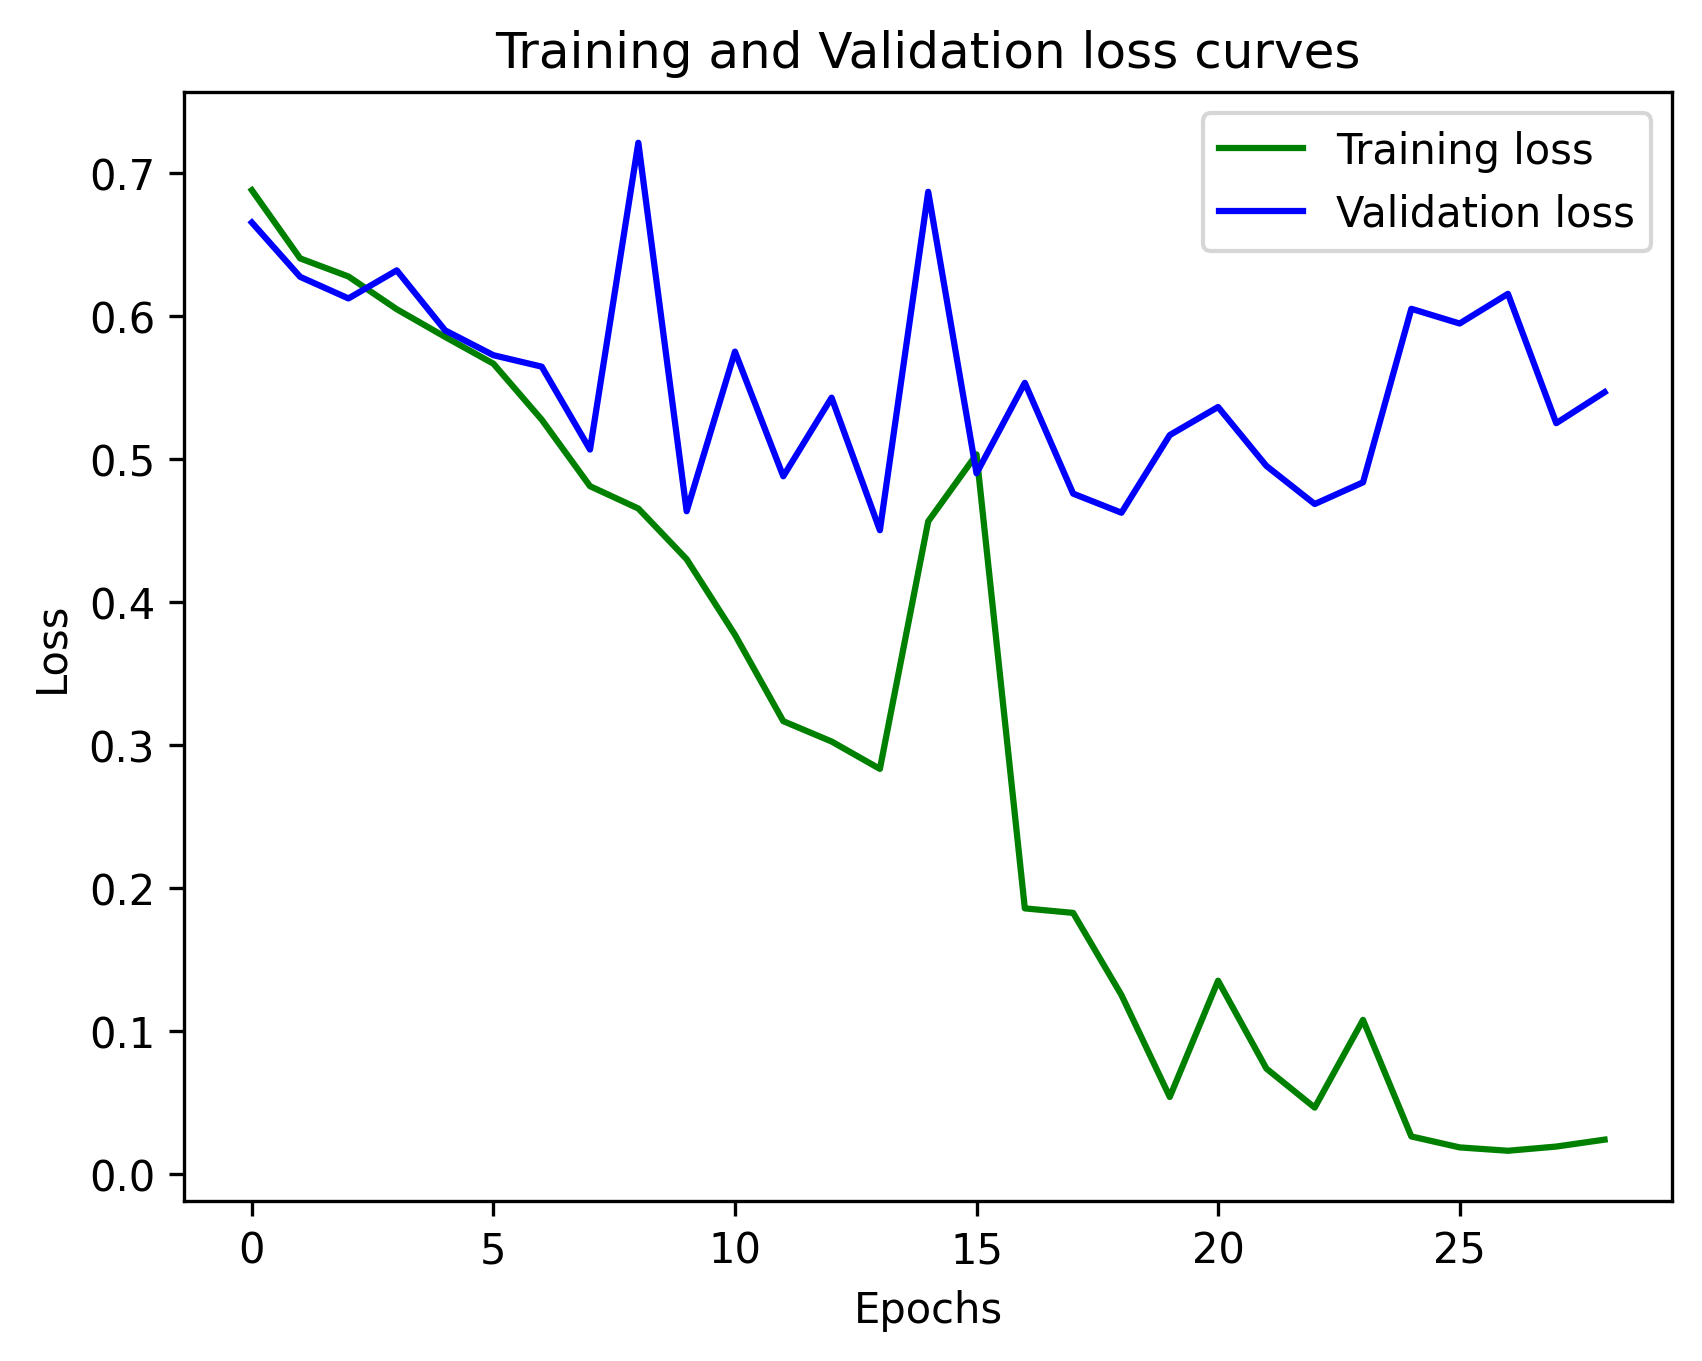

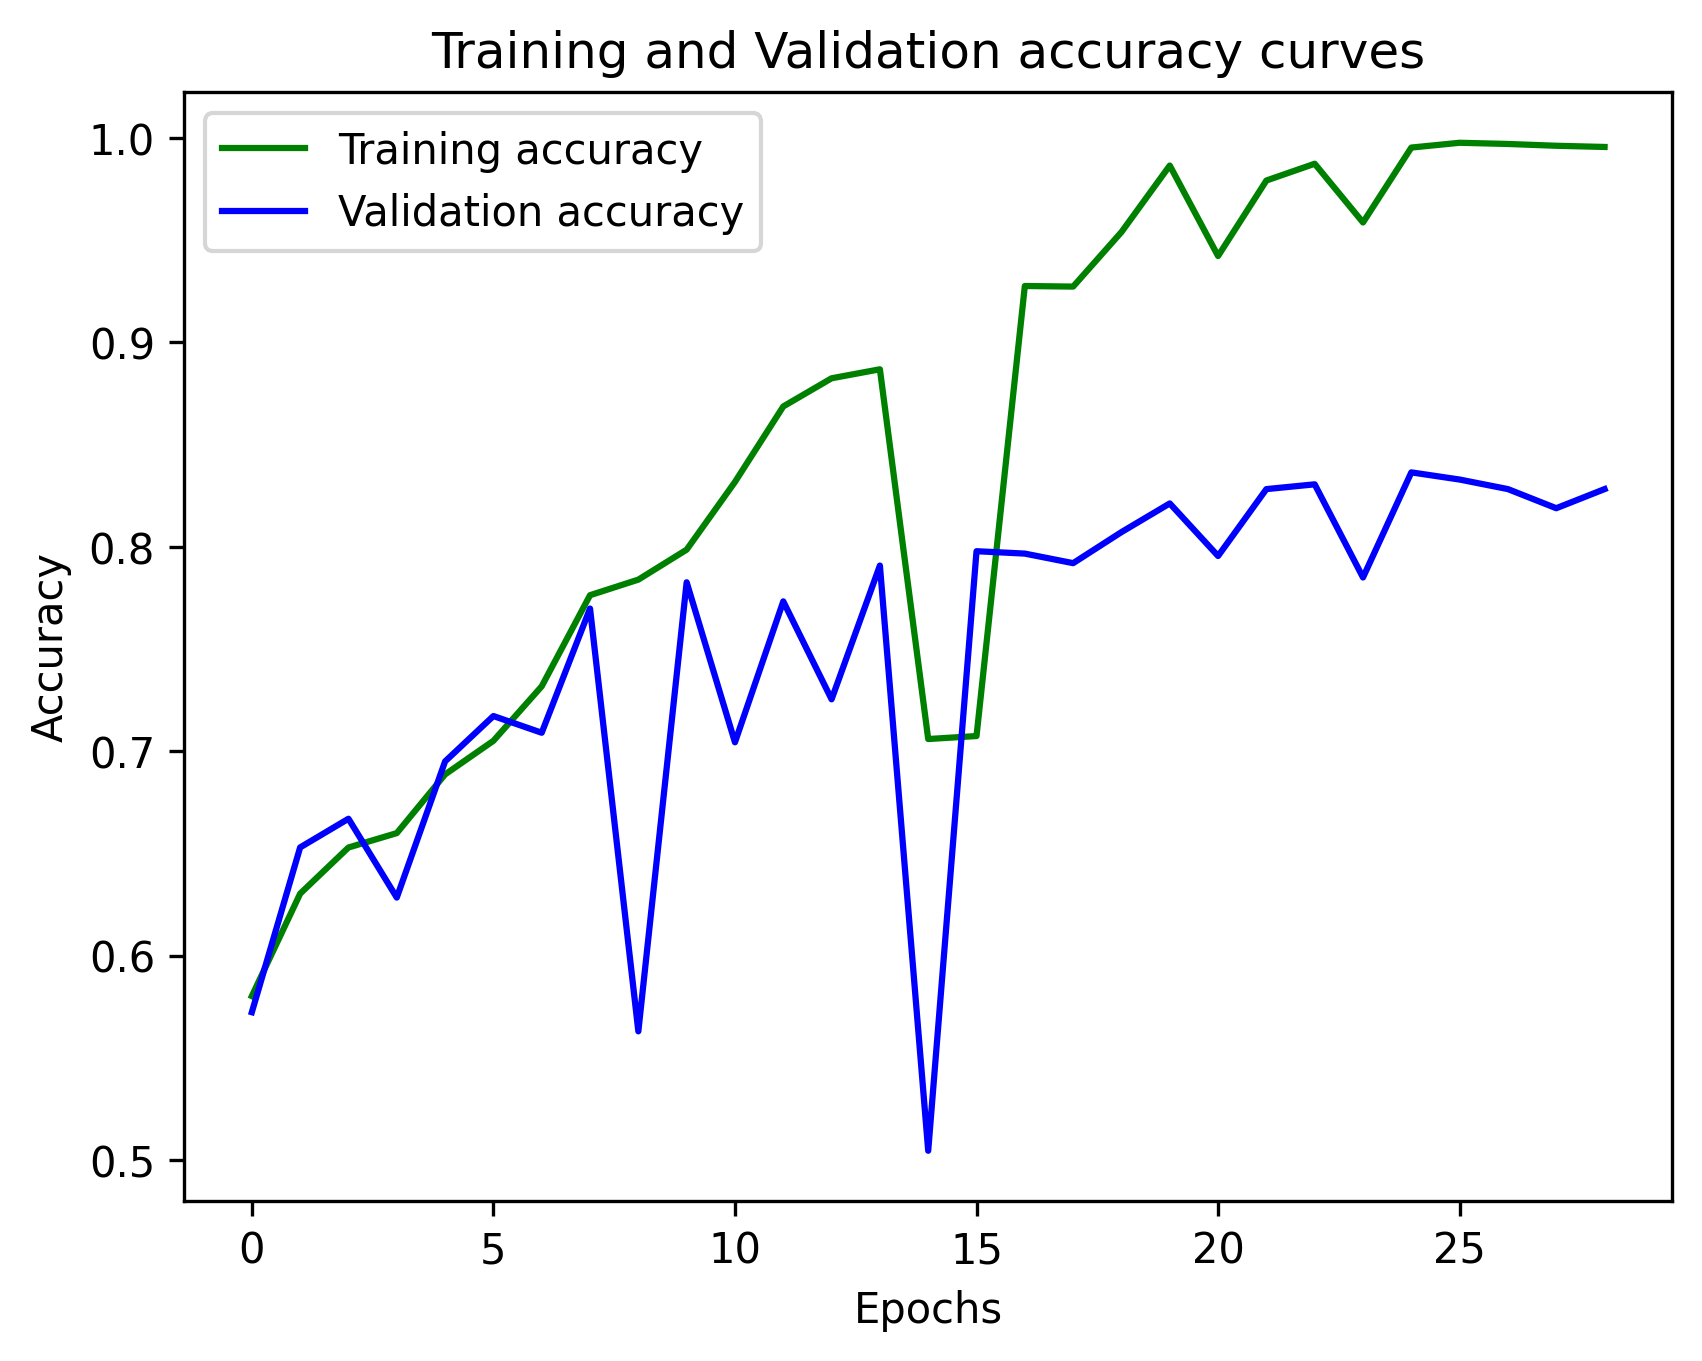

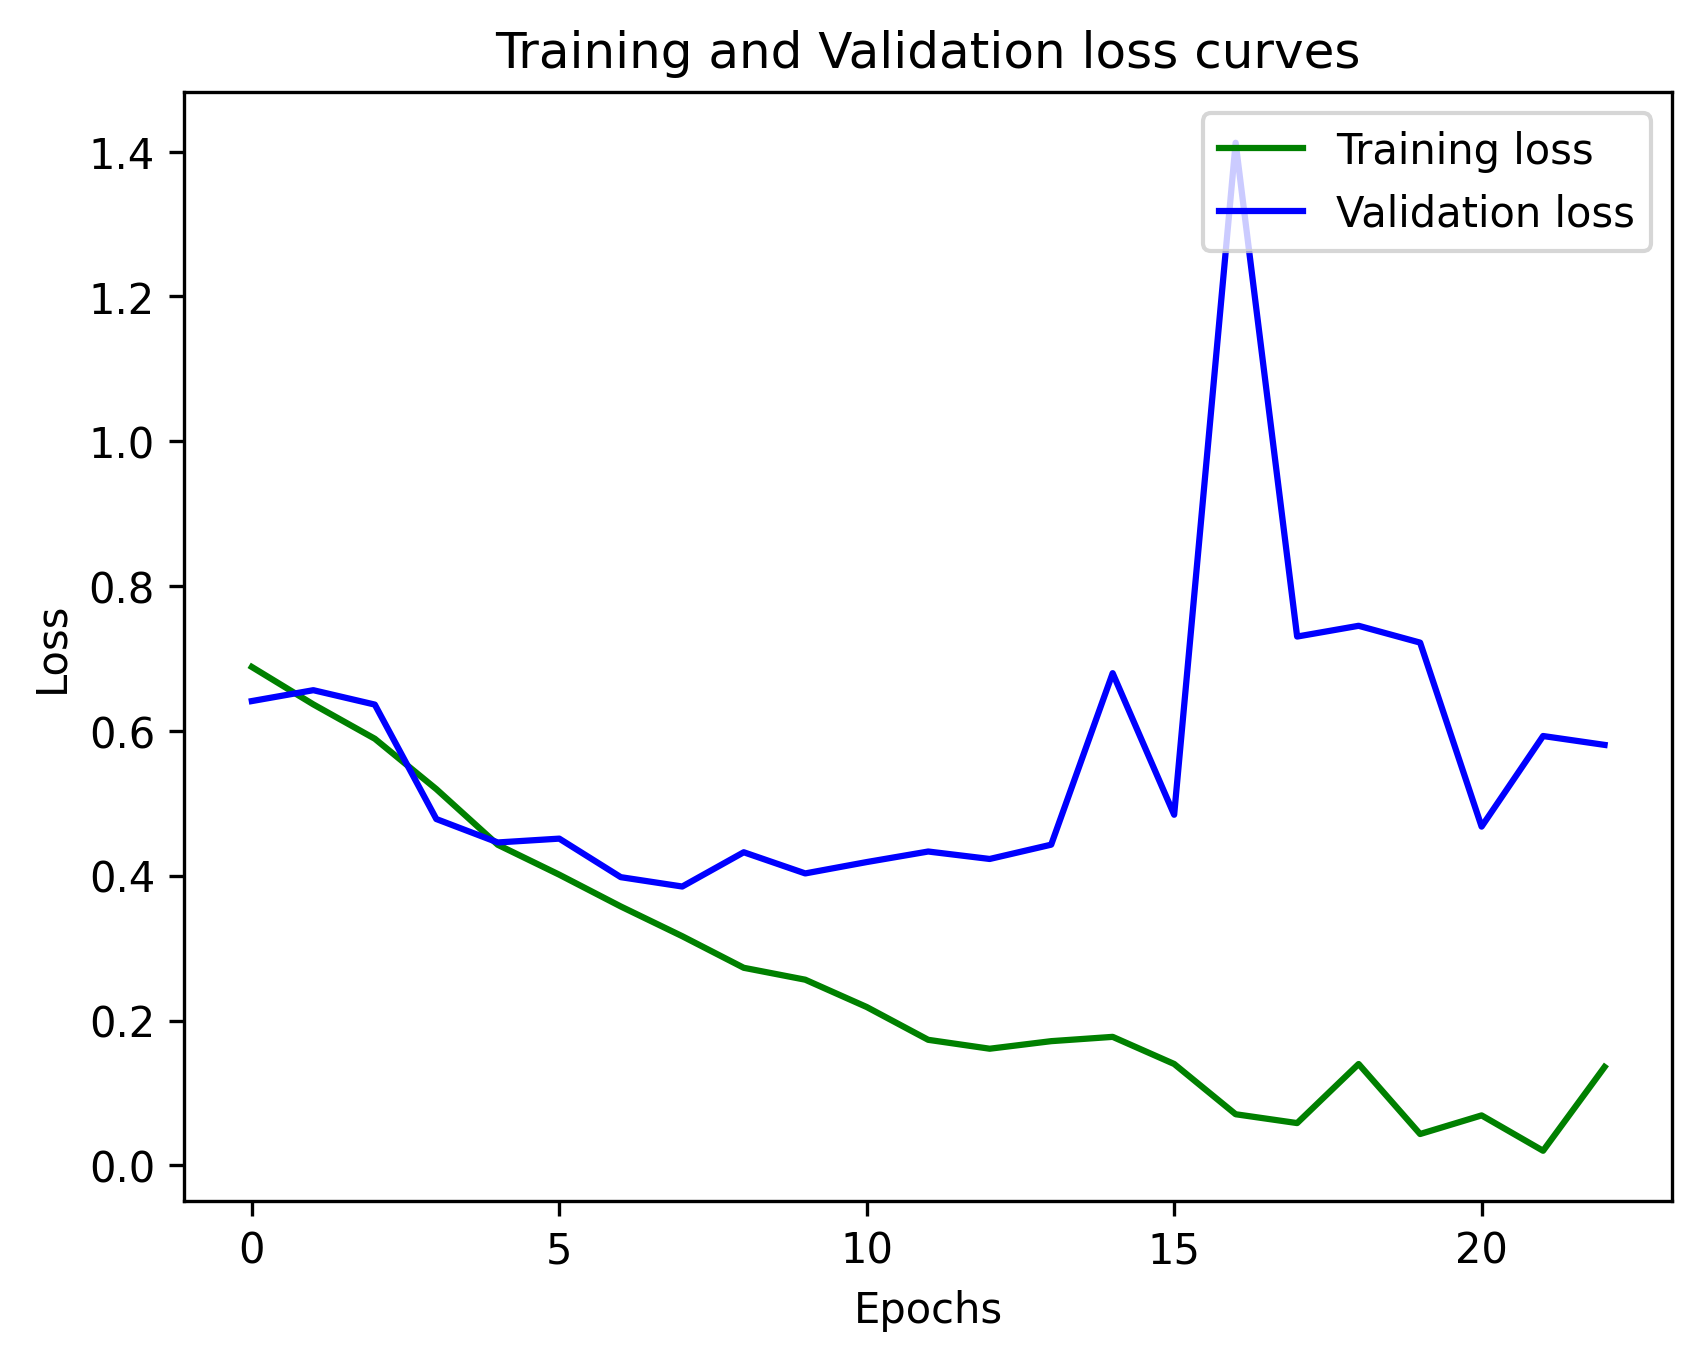

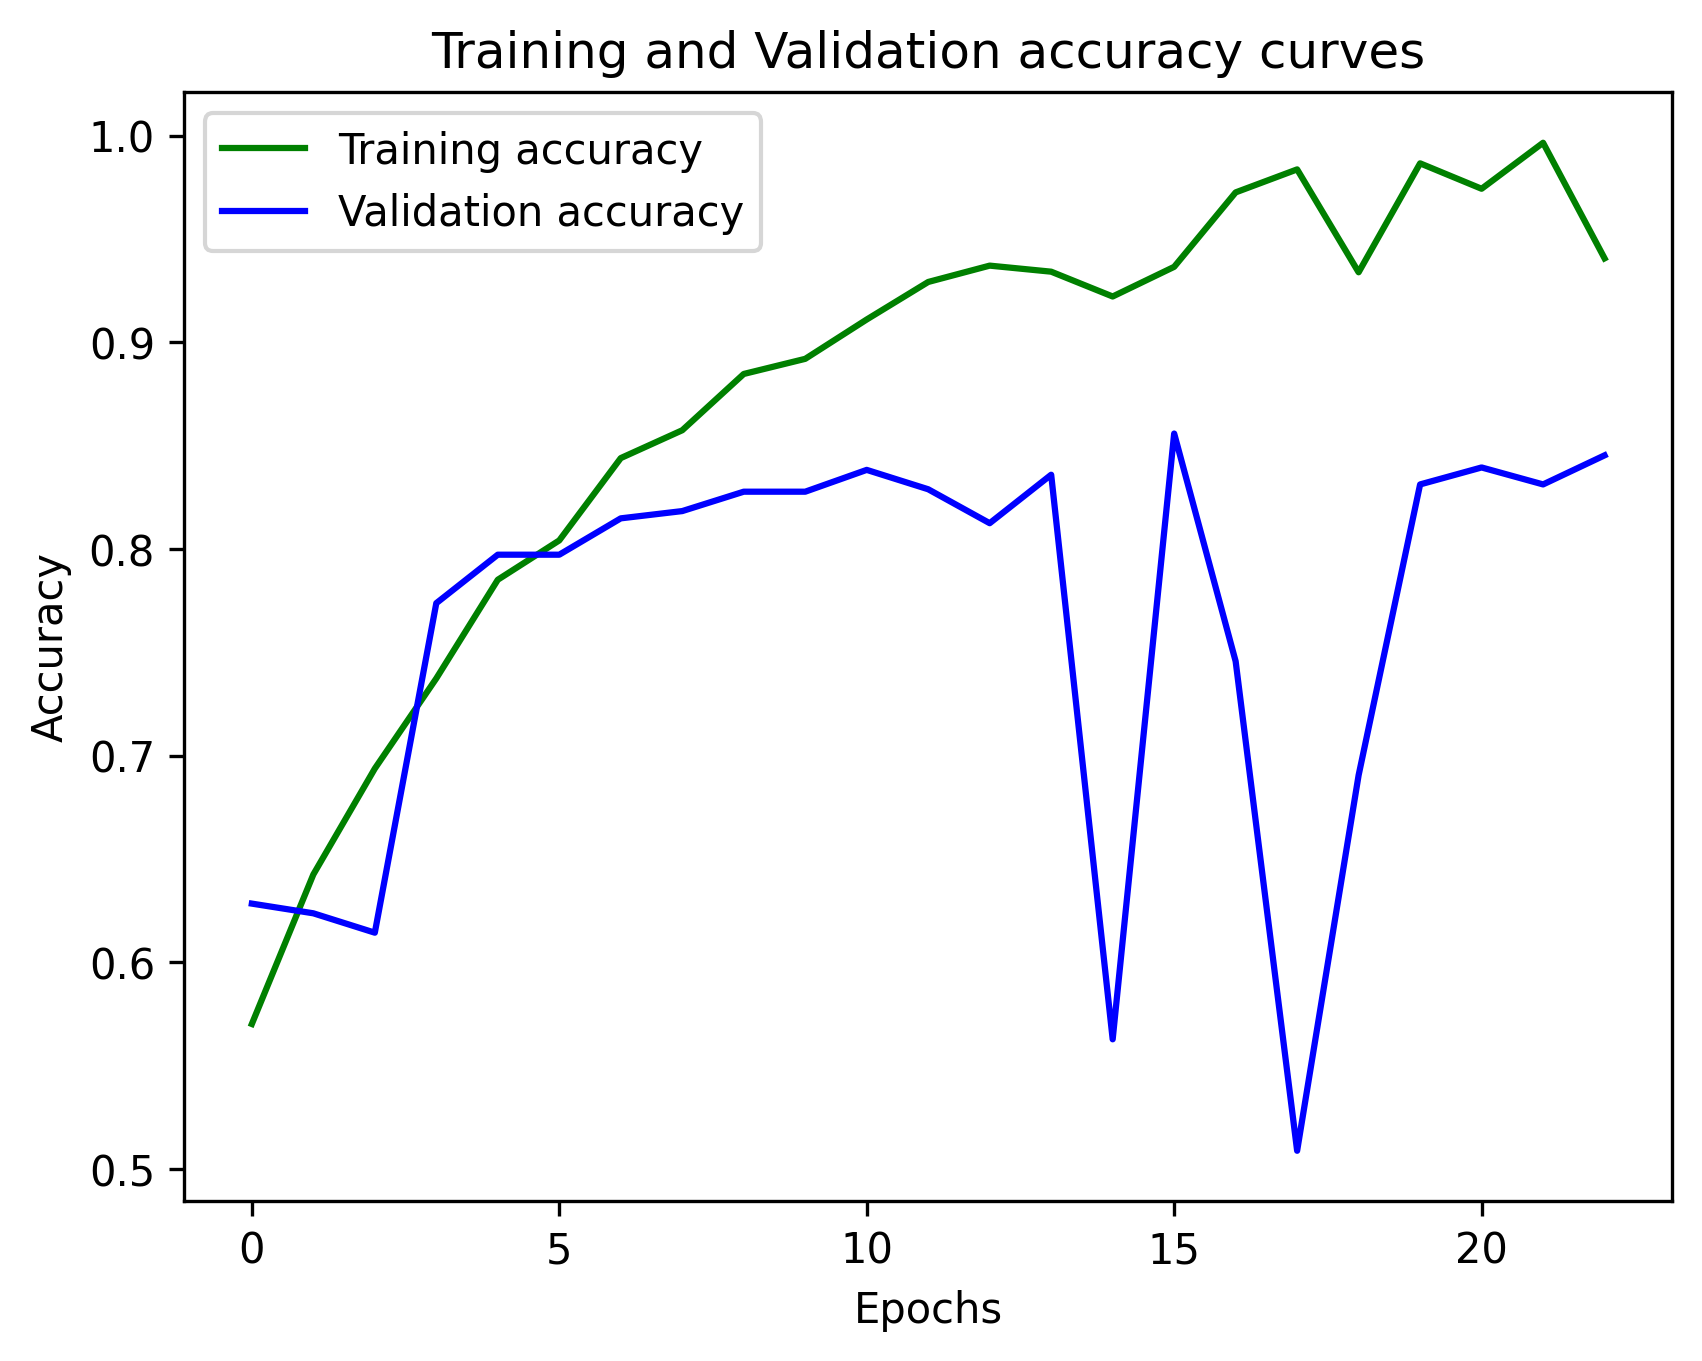

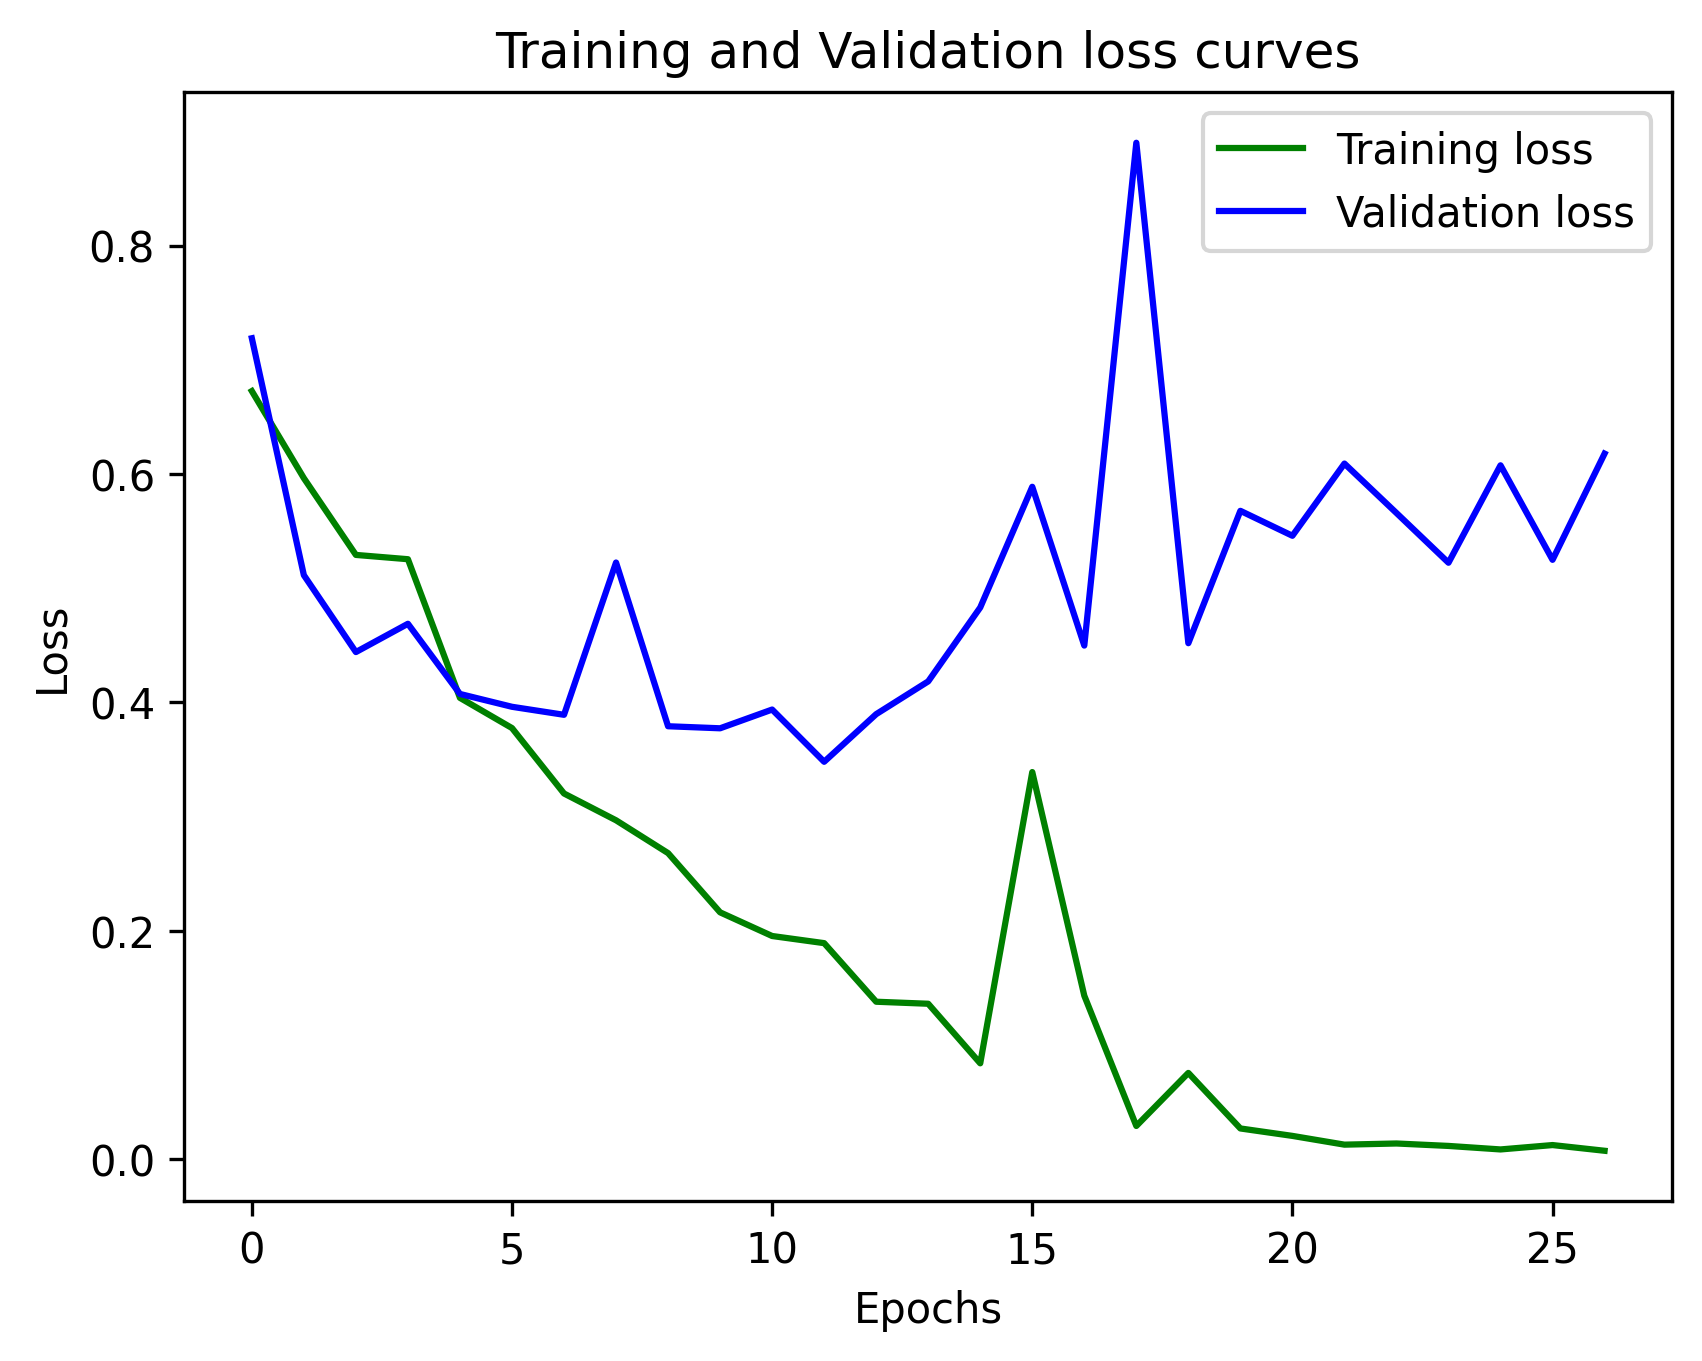

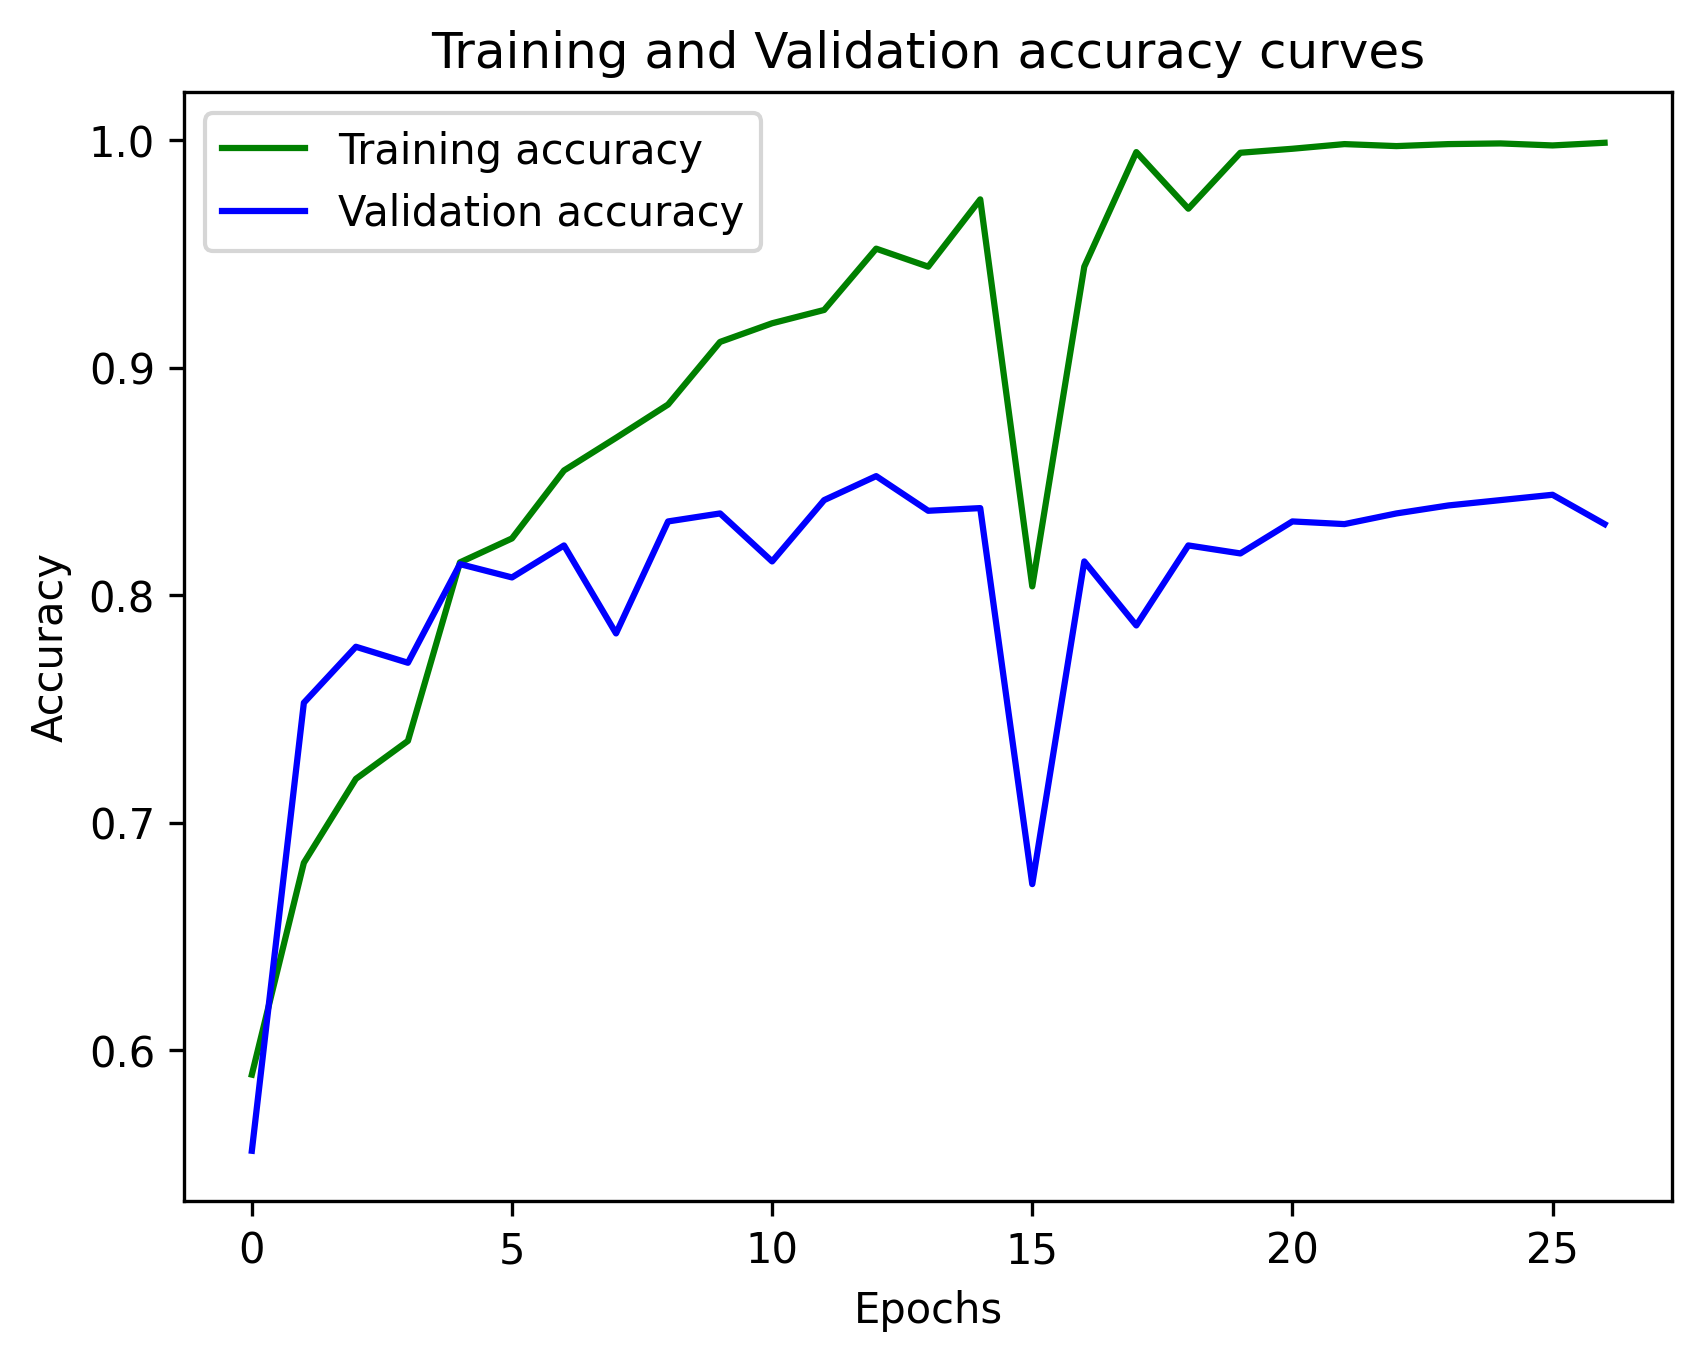

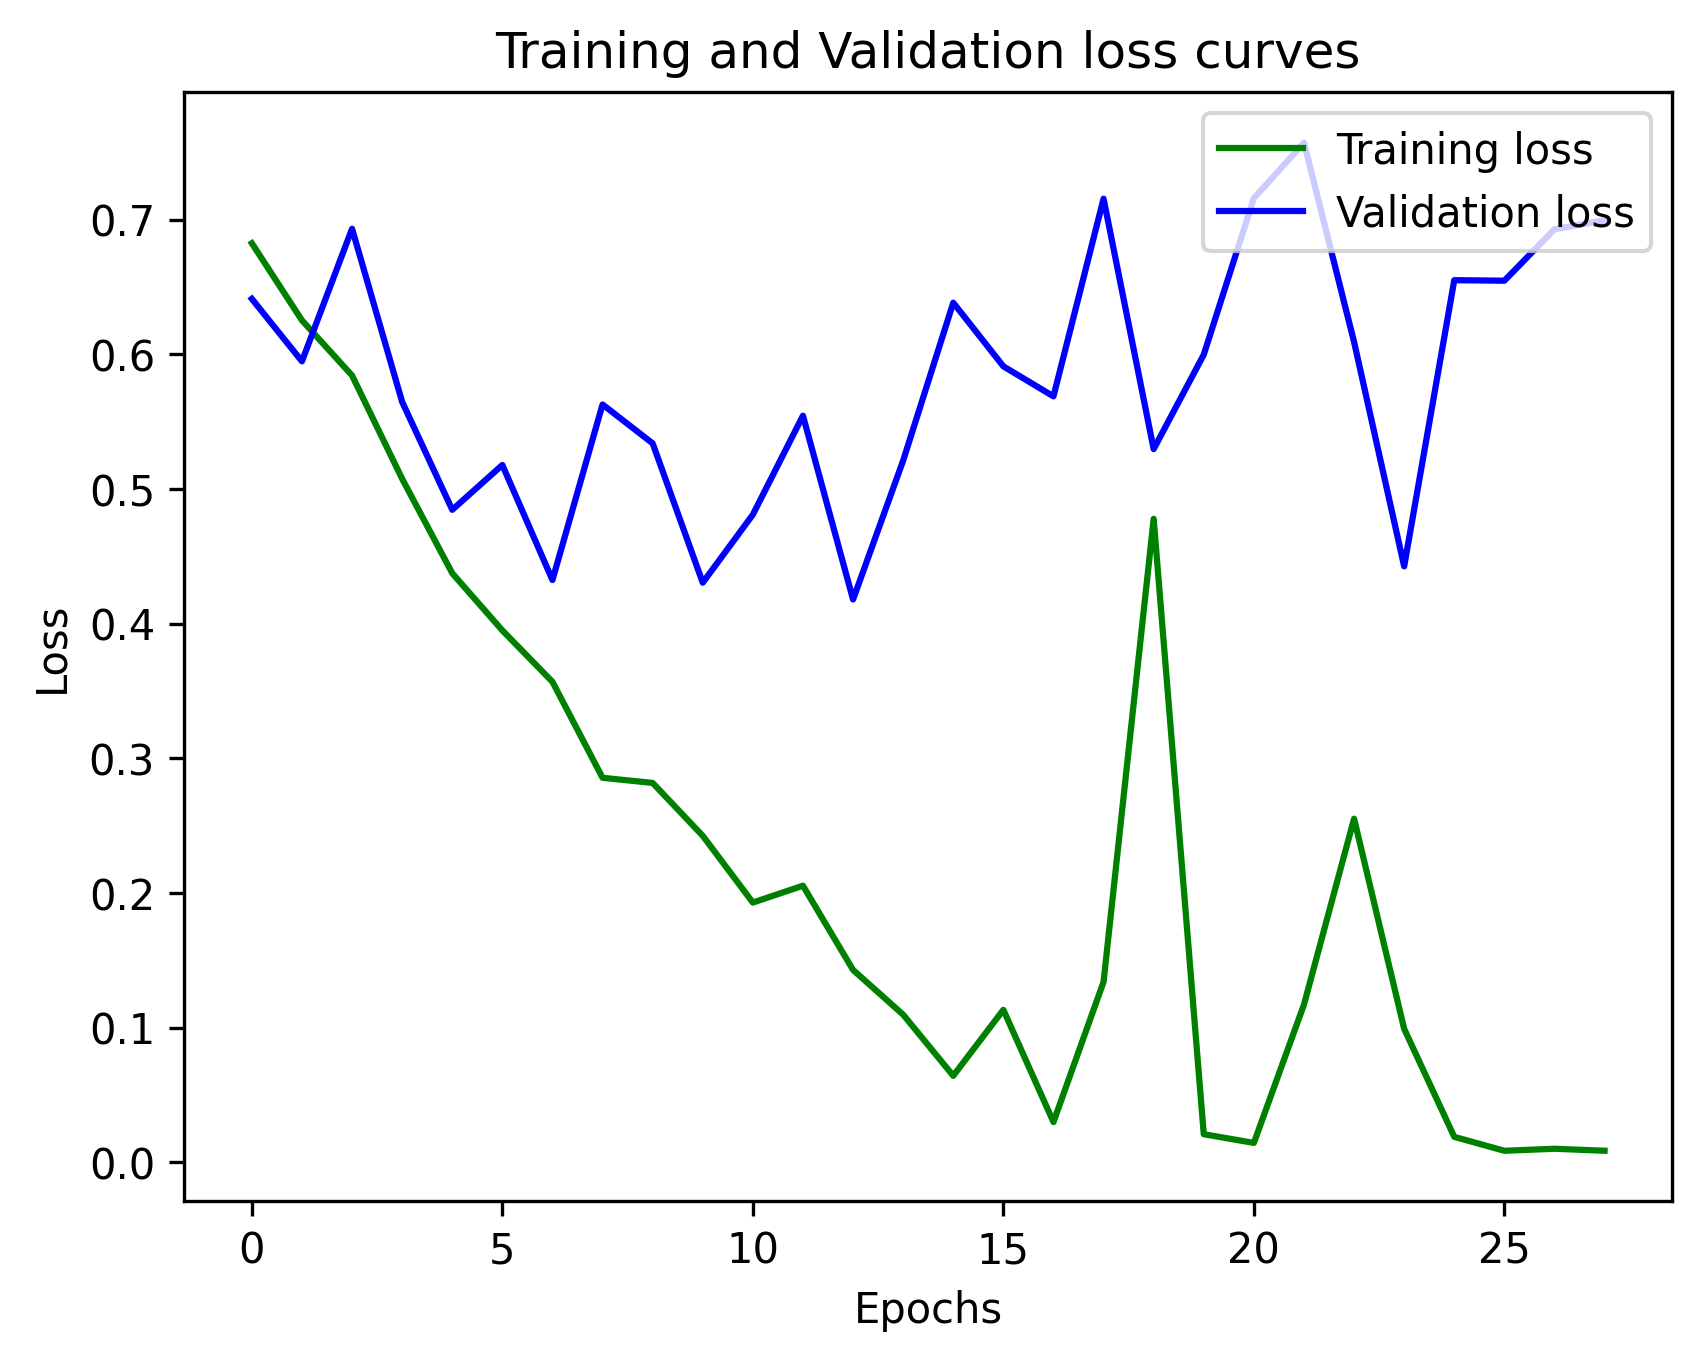

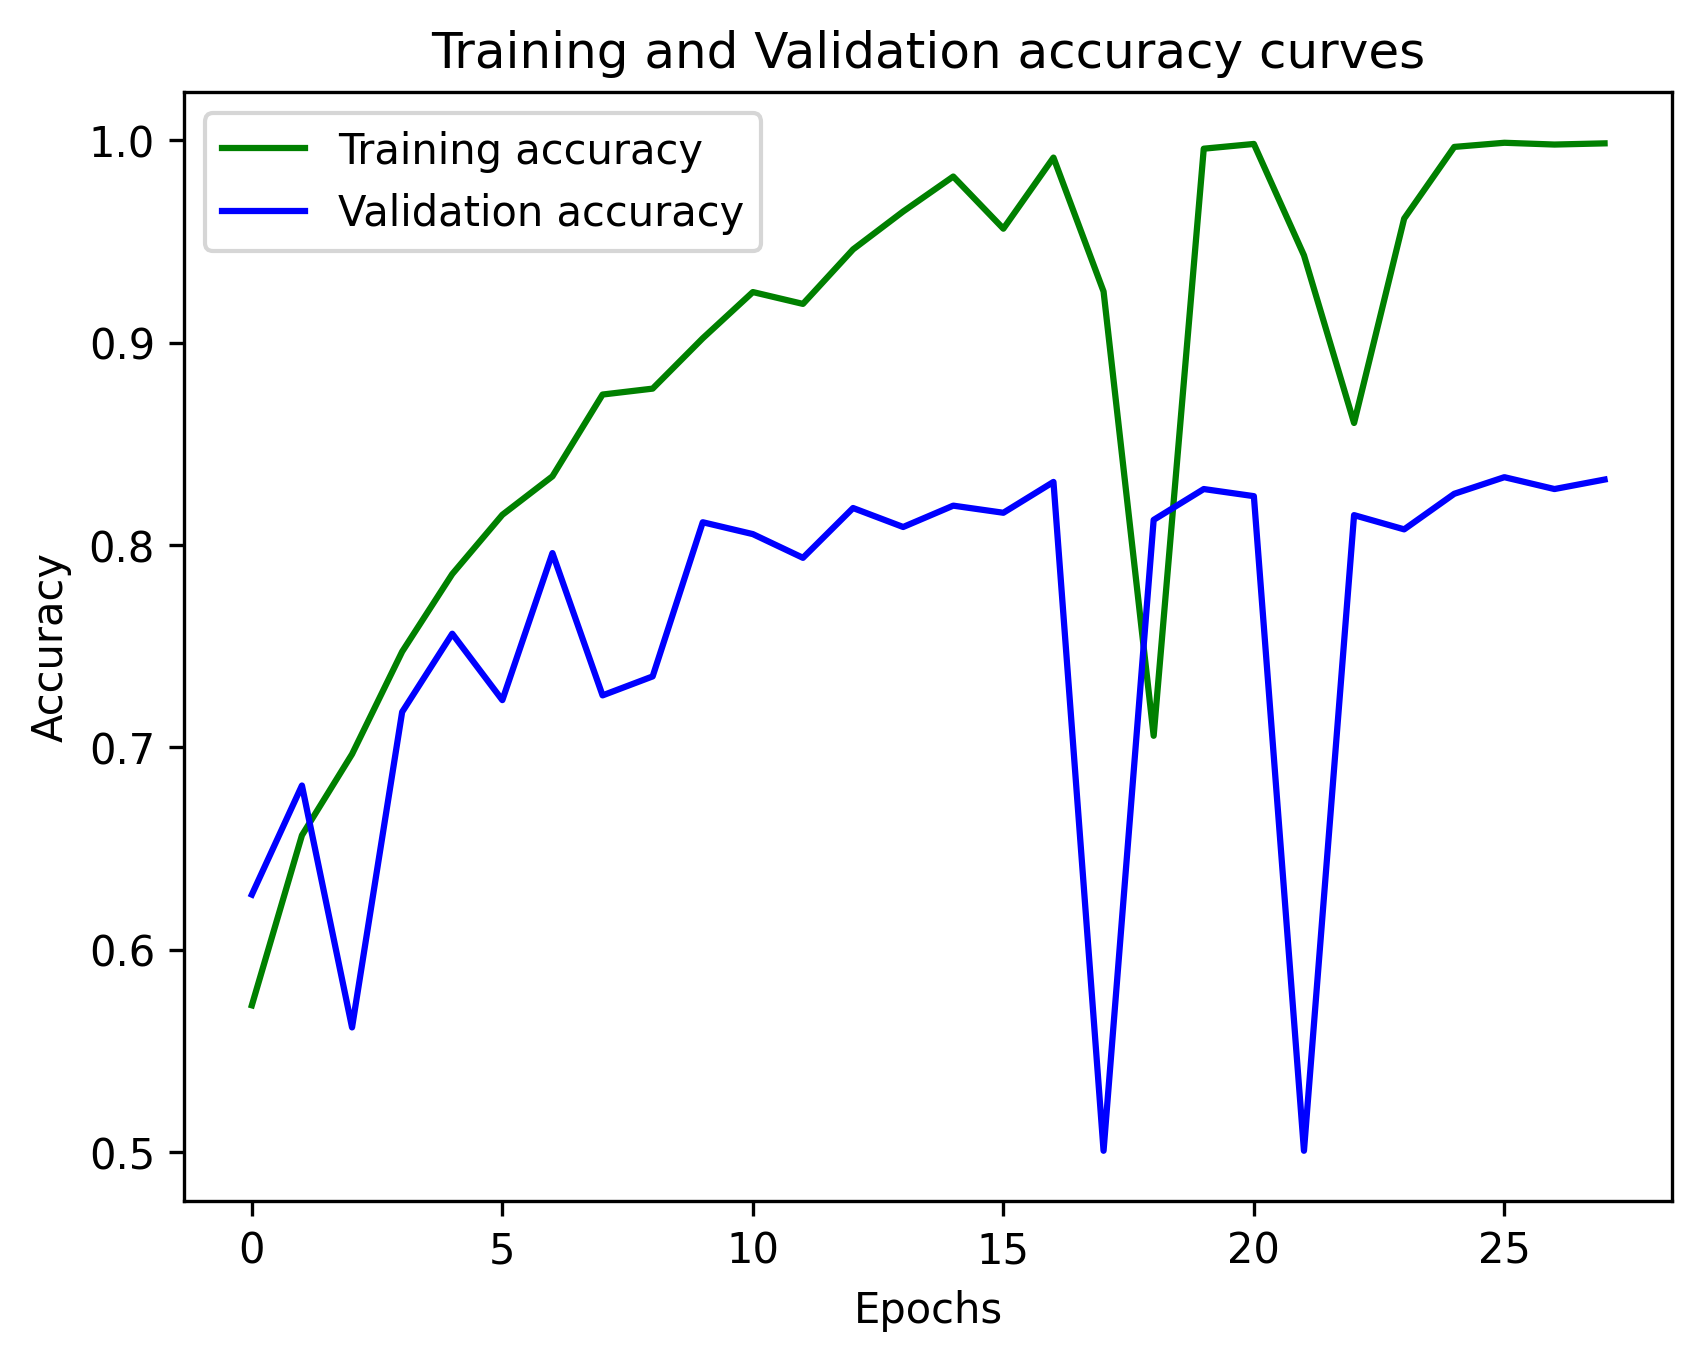

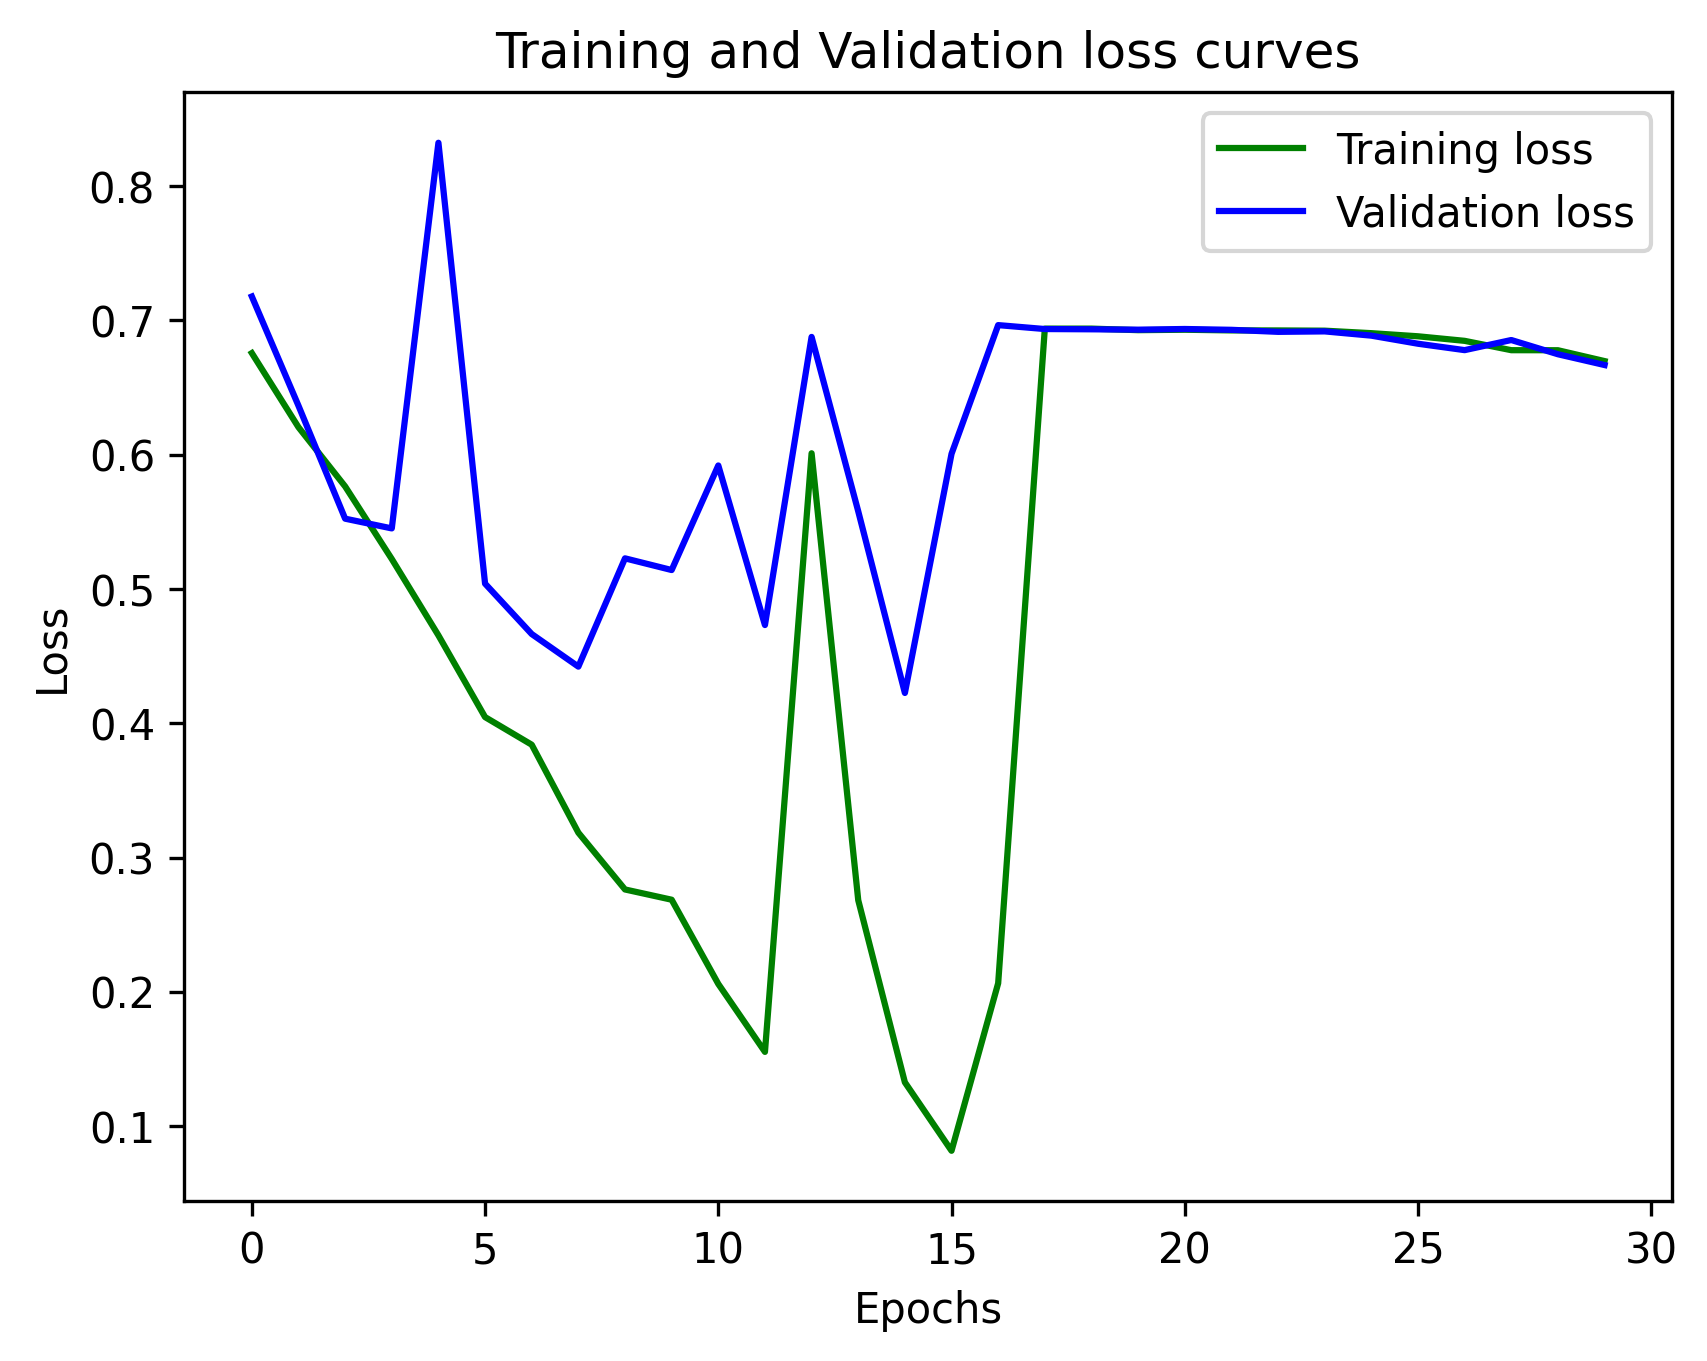

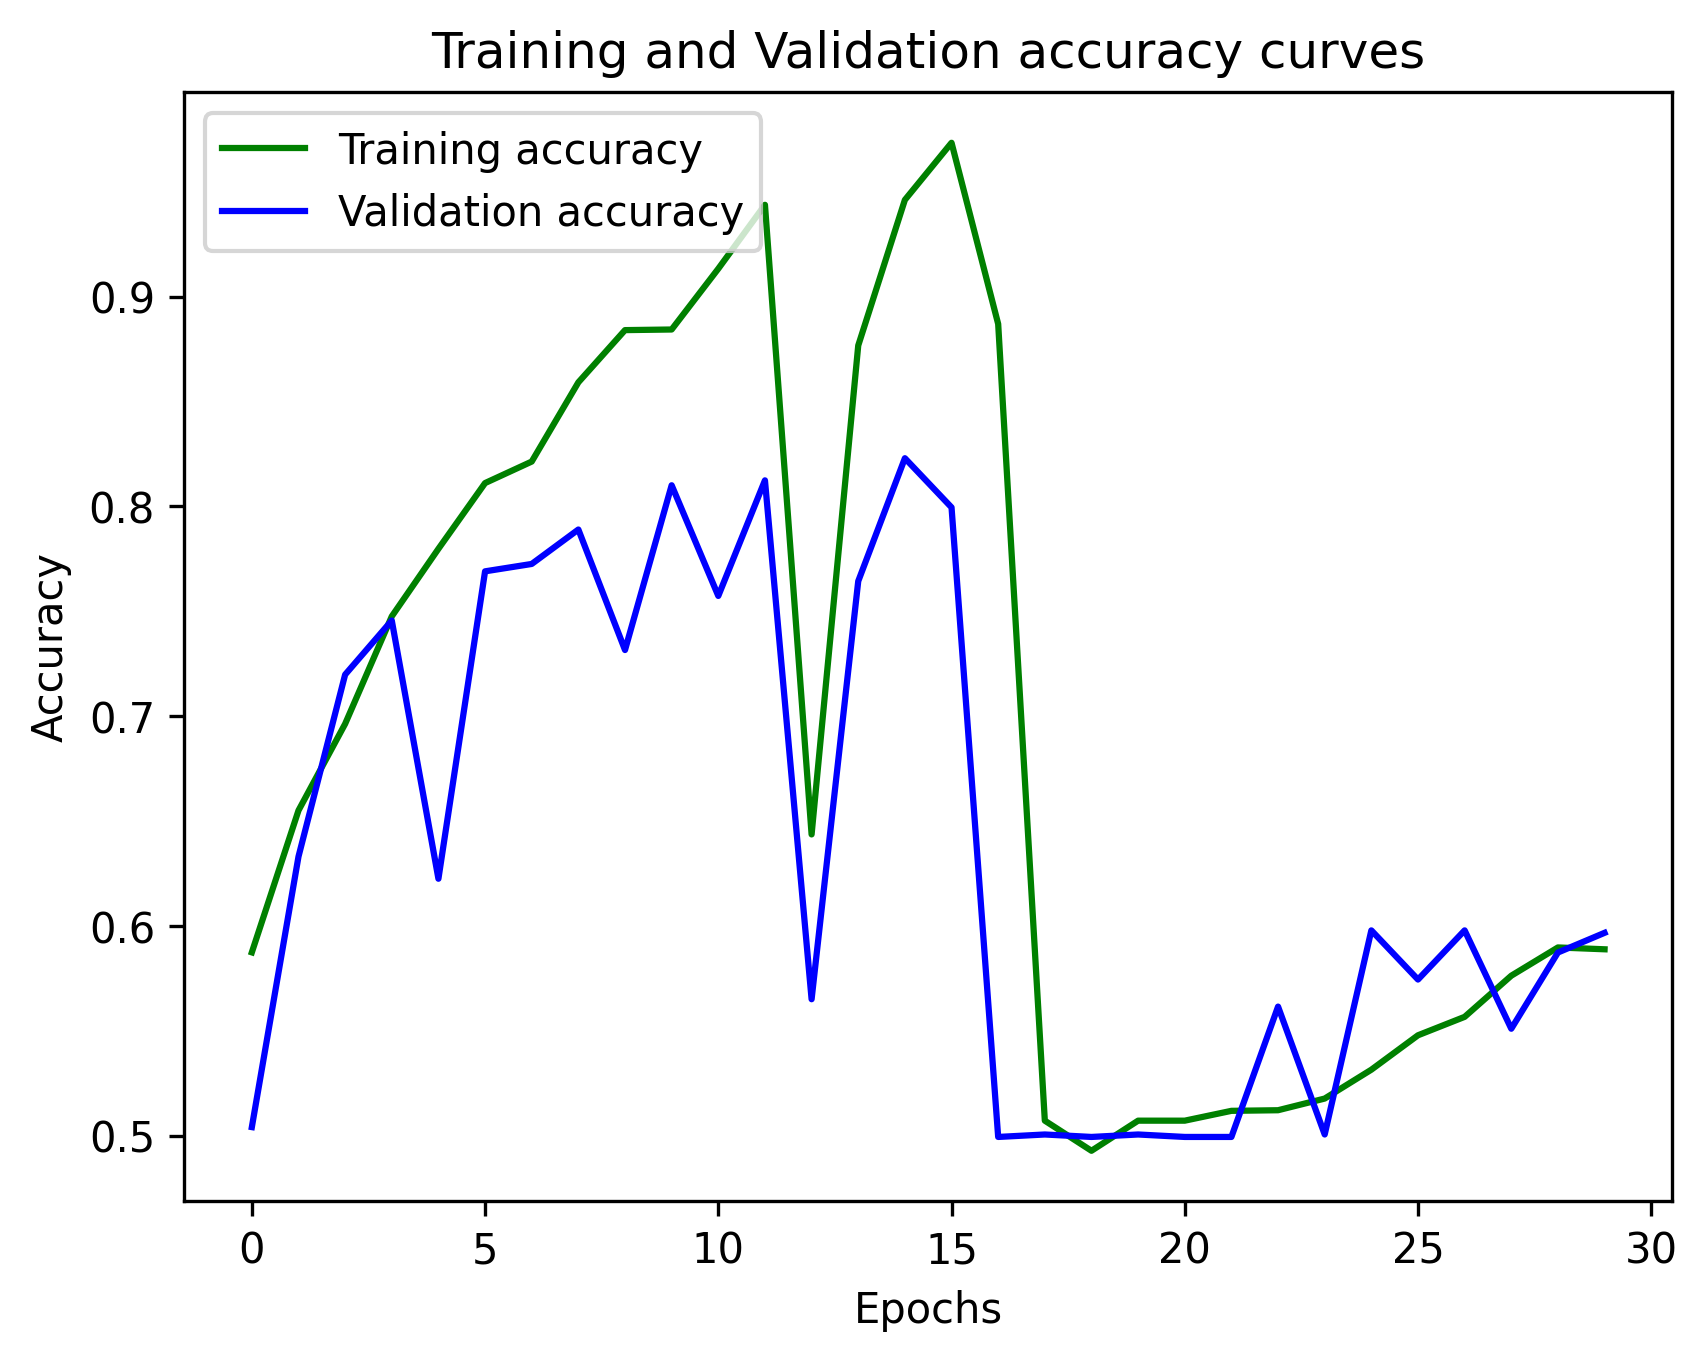

In [9]:
training_times = []

configs = ['Config 0']

print(' ------------\n|EXPERIMENT 1|\n ------------')

for config in configs:
    
    model_conv         = hyperparameters_dict[config][0]
    freeze             = hyperparameters_dict[config][1]
    top_m              = hyperparameters_dict[config][2]
    neurons_last_layer = hyperparameters_dict[config][3]
    initializer_seed   = hyperparameters_dict[config][4]
    optimizer          = hyperparameters_dict[config][5]
    lr                 = hyperparameters_dict[config][6]
    loss_function      = hyperparameters_dict[config][7]
    activation         = hyperparameters_dict[config][8]
    patience           = hyperparameters_dict[config][9]
    batch_size         = hyperparameters_dict[config][10]
    epochs             = hyperparameters_dict[config][11]

    for i in range(k):
        
        fold = i + 1
                                            
        a = i
        b = i+1 if i+1 < 5 else i+1-5
        c = i+2 if i+2 < 5 else i+2-5
        d = i+3 if i+3 < 5 else i+3-5
        e = i+4 if i+4 < 5 else i+4-5
    
        print('\n')
        print(f'FOLD {fold}\n--------------\n')
    
        # Generate k-fold training and validation sample
        train_paths  = X_y_folds[a][0] + X_y_folds[b][0] + X_y_folds[c][0] + X_y_folds[d][0]
        train_labels = X_y_folds[a][1] + X_y_folds[b][1] + X_y_folds[c][1] + X_y_folds[d][1]
        val_paths    = X_y_folds[e][0]
        val_labels   = X_y_folds[e][1]
    
        train_gen = DataGenerator(
            image_paths=train_paths,
            labels=train_labels,
            batch_size=batch_size,
            img_size=img_size
        )
        val_gen = DataGenerator(
            image_paths=val_paths,
            labels=val_labels,
            batch_size=batch_size,
            img_size=img_size
        )
    
        model_fold = f'{fold}'

        start = time.perf_counter()

        My_Custom_Model(
            train_gen, val_gen, img_size,
            model_conv, freeze, top_m, neurons_last_layer,
            initializer_seed, optimizer, lr, loss_function,
            activation, metrics, patience, batch_size,
            epochs, model_dir, model_fold, print_report, subset
        ).runall()

        end = time.perf_counter()
        training_times.append(end - start)


In [10]:
# TRAINING TIME SUMMARY (GLOBAL)

# Build dataframe with training times
df_times = pd.DataFrame({
    'fold': list(range(1, len(training_times) + 1)),
    'training_time_sec': training_times,
    'training_time_min': [t / 60 for t in training_times]
})

# Display nicely in notebook
display(df_times)

# Print summary statistics
print('\n==============================')
print('TRAINING TIME SUMMARY')
print('==============================')
print(f'Mean training time: {df_times["training_time_min"].mean():.2f} minutes')
print(f'Std training time:  {df_times["training_time_min"].std():.2f} minutes')
print('==============================')

# Save to disk (verifiable)
output_path = os.path.join(model_dir, f'training_times_{subset}.csv')
df_times.to_csv(output_path, index=False)

print(f'\n[INFO] Training time summary saved to:')
print(output_path)


,fold,training_time_sec,training_time_min
0,1,9607.035914,160.117265
1,2,7640.037150,127.333953
2,3,8825.869029,147.097817
3,4,9493.404756,158.223413
4,5,11519.015308,191.983588



TRAINING TIME SUMMARY
Mean training time: 156.95 minutes
Std training time:  23.52 minutes

[INFO] Training time summary saved to:
Models/TC_Canon_CZC_RAD_MIN_HURJC_all_1.0_no_unet/training_times_TC_Canon_CZC_RAD_MIN_HURJC_all_1.0_no_unet.csv


### **6. Summary and Conclusions**

The training process, monitored via 5-fold Stratified Cross-Validation, confirms the successful convergence of the VGG19 model for identifying Calcific Tendinitis. The accuracy and loss metrics recorded in this notebook demonstrate a consistent learning trajectory: a rapid optimization phase during the initial epochs followed by a steady stabilization. The custom Data Generator proved to be a robust solution for handling the dataset, maintaining high computational throughput without compromising the integrity of the image data.

Analysis of the training logs reveals that the model effectively captured the radiological patterns across images from various Canon Inc. workstations. While the training curves show high performance, the validation curves display minor fluctuations and a slight gap typical of medical imaging tasks, indicating a manageable level of overfitting. However, the overall stability across all five folds validates the choice of hyperparameters and confirms that the model is not relying on artifacts from a single data split.

In conclusion, this notebook establishes a high-performance baseline for CTRC diagnosis using Deep Learning. The successful integration of a scalable data loading system and a fine-tuned CNN architecture provides a reliable foundation for the next phase of the project: extracting deep features for hybrid ML models and conducting final prospective testing. These results represent a significant step toward an automated clinical decision support tool for rotator cuff pathologies.